In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
# For image processing and augmentation
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# For deep learning model building using TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.applications import MobileNetV2  # or any other base model

# For Grad-CAM visualization
import tensorflow.keras.backend as K

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


Classes found: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Class: adenocarcinoma, Number of images: 338
Class: large.cell.carcinoma, Number of images: 187
Class: normal, Number of images: 215
Class: squamous.cell.carcinoma, Number of images: 260


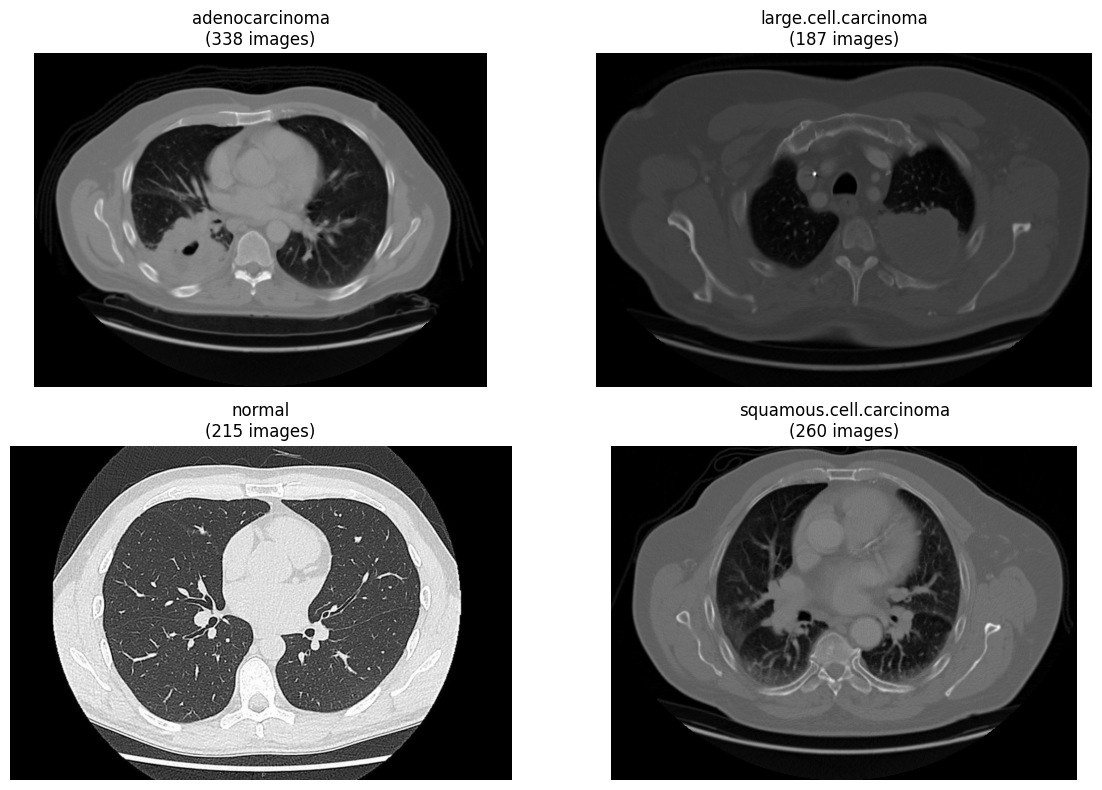

In [4]:

# Define the dataset path
data_dir = r'/content/drive/MyDrive/Datasets/Chest CT-Scan images Dataset'

# List subdirectories (classes)
classes = sorted([cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))])
print("Classes found:", classes)

# Display a few sample images from each class
num_classes = len(classes)
if num_classes == 0:
    print("No classes found in the dataset directory.")
else:
    # Dynamically adjust the subplot grid
    num_rows = (num_classes + 1) // 2  # Ensure enough rows for all classes
    plt.figure(figsize=(12, 8))

    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # Count the number of valid images in the class
        image_count = len(images)
        print(f"Class: {cls}, Number of images: {image_count}")

        if image_count == 0:
            print(f"No valid images found in class '{cls}'. Skipping...")
            continue

        # Read the first valid image in the folder
        img_path = os.path.join(cls_path, images[0])
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_path}. Skipping...")
            continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(num_rows, 2, i+1)
        plt.imshow(img)
        plt.title(f"{cls}\n({image_count} images)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

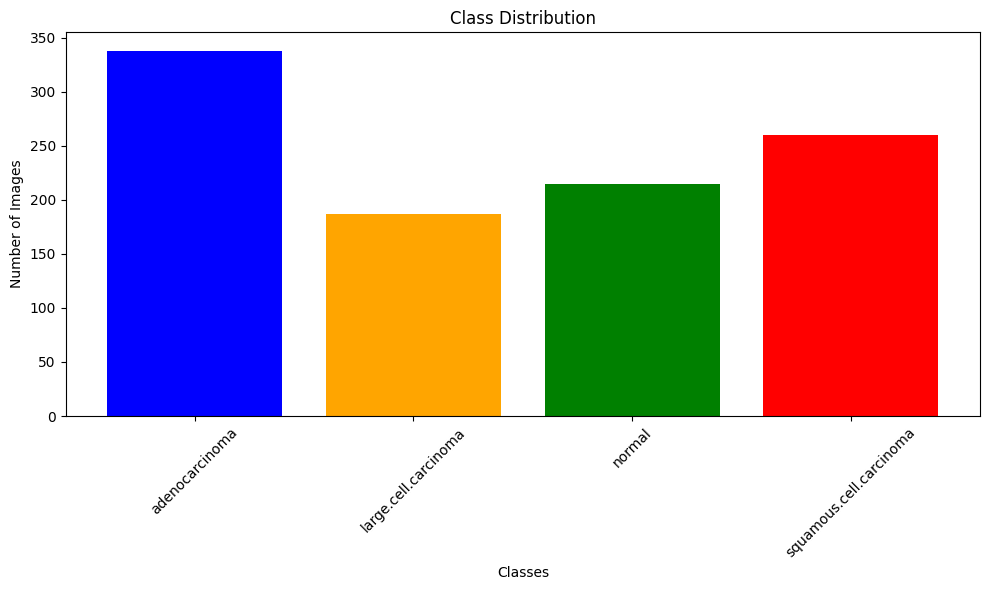

In [5]:
import matplotlib.pyplot as plt

# Class names and their respective counts
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
class_counts = [338, 187, 215, 260]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color=['blue', 'orange', 'green', 'red'])
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Classes found: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Class: adenocarcinoma, Number of images: 338
Class: large.cell.carcinoma, Number of images: 187
Class: normal, Number of images: 215
Class: squamous.cell.carcinoma, Number of images: 260


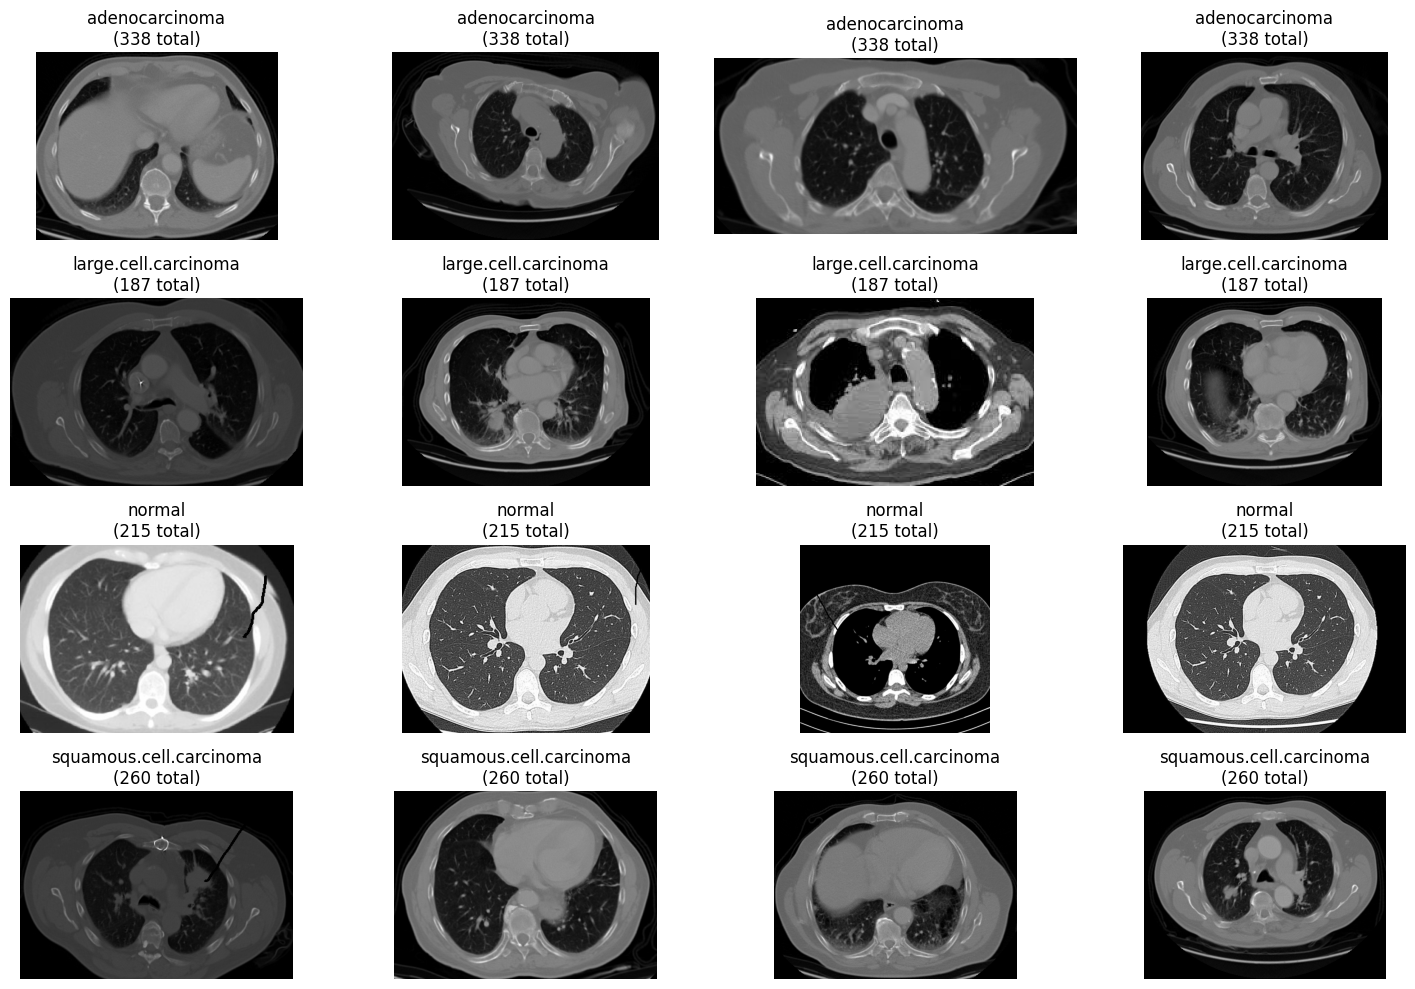

In [6]:

# List subdirectories (classes)
classes = sorted([cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))])
print("Classes found:", classes)

# Display four random sample images from each class
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    cls_path = os.path.join(data_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Count the number of valid images in the class
    image_count = len(images)
    print(f"Class: {cls}, Number of images: {image_count}")

    if image_count == 0:
        print(f"No valid images found in class '{cls}'. Skipping...")
        continue

    # Select up to 4 random images
    random_images = random.sample(images, min(4, image_count))

    for j, img_name in enumerate(random_images):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_path}. Skipping...")
            continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(len(classes), 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(f"{cls}\n({image_count} total)")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Create training and validation image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    validation_split=0.2,     # 80% training, 20% validation
    rotation_range=15,        # Randomly rotate images by up to 15 degrees
    horizontal_flip=True,     # Randomly flip images horizontally
)

# Training generator (80% of the data)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    subset='training',                    # Use the training subset
    class_mode='categorical'              # One-hot encode labels
)

# Validation generator (20% of the data)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    subset='validation',                  # Use the validation subset
    class_mode='categorical'              # One-hot encode labels
)

# Print class indices to verify correctness
print("Class indices:", train_generator.class_indices)

Found 801 images belonging to 4 classes.
Found 199 images belonging to 4 classes.
Class indices: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a custom CNN
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,884 (42.61 MB)

 Trainable params: 11,170,180 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [9]:

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model

# Build the classification head
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)  # Use the base model in inference mode
x = GlobalAveragePooling2D()(x)        # Reduce spatial dimensions
x = BatchNormalization()(x)            # Normalize activations
x = Dropout(0.2)(x)                    # Add dropout for regularization
outputs = Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,268,228 (8.65 MB)

 Trainable params: 7,684 (30.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3381 - loss: 1.7913 - val_accuracy: 0.2814 - val_loss: 1.4205
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 750ms/step - accuracy: 0.3663 - loss: 1.5282 - val_accuracy: 0.3819 - val_loss: 1.1733
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 752ms/step - accuracy: 0.4160 - loss: 1.3685 - val_accuracy: 0.4422 - val_loss: 1.1348
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 686ms/step - accuracy: 0.4858 - loss: 1.2667 - val_accuracy: 0.4824 - val_loss: 1.0775
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 775ms/step - accuracy: 0.4944 - loss: 1.2758 - val_accuracy: 0.5477 - val_loss: 1.0105
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - accuracy: 0.5133 - loss: 1.1911 - val_accuracy: 0.5176 - val_loss: 0.9984
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 821ms/step - accuracy: 0.5553 - loss: 1.0547 - val_accuracy: 0.5528 - val_loss: 0.9782
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 712ms/step - accuracy: 0.5373 - loss: 1.0763 - val_accurac

In [11]:
# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tuned = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3103 - loss: 1.8397 - val_accuracy: 0.6482 - val_loss: 0.7243
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 697ms/step - accuracy: 0.4918 - loss: 1.3455 - val_accuracy: 0.6131 - val_loss: 0.8275
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 786ms/step - accuracy: 0.5929 - loss: 1.1052 - val_accuracy: 0.5879 - val_loss: 0.9024
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 704ms/step - accuracy: 0.5896 - loss: 1.0437 - val_accuracy: 0.5276 - val_loss: 0.9596
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 766ms/step - accuracy: 0.5755 - loss: 0.9926 - val_accuracy: 0.5578 - val_loss: 0.9795
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 788ms/step - accuracy: 0.6818 - loss: 0.8268 - val_accuracy: 0.5126 - val_loss: 1.0406


In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.6377 - loss: 0.7751
Validation Loss: 0.783203661441803
Validation Accuracy: 0.6381909251213074


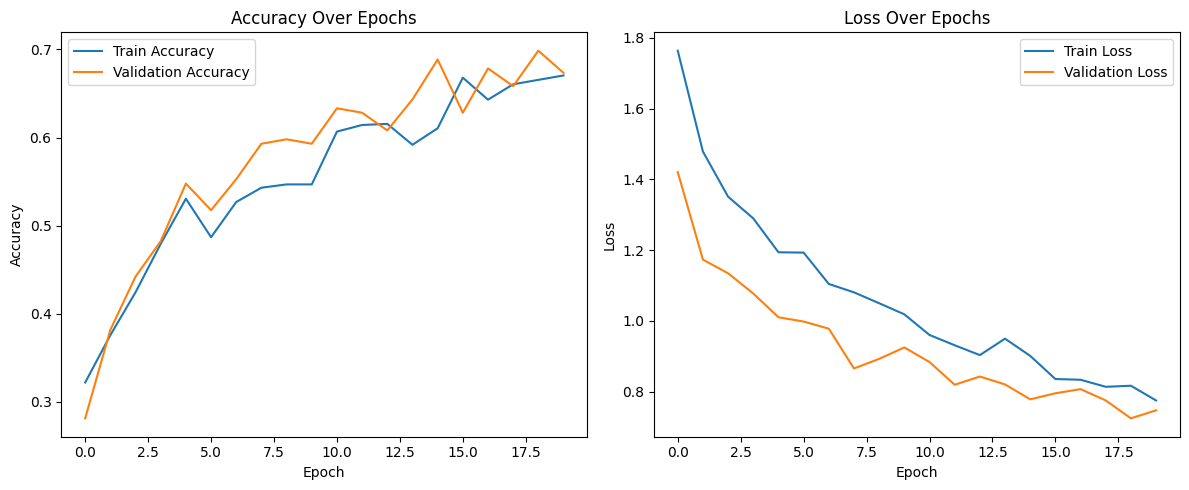

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
pip install keras-resnet

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Define image dimensions and batch size
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 32

# Load ResNet50 with pre-trained weights (on ImageNet)
input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
resnet_base = ResNet50(include_top=False, weights="imagenet", input_tensor=input_layer)
resnet_base.trainable = False  # Freeze the base model

# Build the classification head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = BatchNormalization()(x)      # Normalize activations
x = Dropout(0.2)(x)              # Add dropout for regularization
output_layer = Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the model
resnet_model = Model(inputs=resnet_base.input, outputs=output_layer)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print the model summary
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,604,100 (90.04 MB)

 Trainable params: 12,292 (48.02 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
training_history = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_175']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2186 - loss: 1.6200 - val_accuracy: 0.2613 - val_loss: 1.4376
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - accuracy: 0.4167 - loss: 1.2756 - val_accuracy: 0.2613 - val_loss: 1.3689
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 785ms/step - accuracy: 0.4495 - loss: 1.1550 - val_accuracy: 0.3367 - val_loss: 1.3226
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 817ms/step - accuracy: 0.4891 - loss: 1.0845 - val_accuracy: 0.3618 - val_loss: 1.2916
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 800ms/step - accuracy: 0.5351 - loss: 1.0211 - val_accuracy: 0.3920 - val_loss: 1.2669
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.5288 - loss: 1.0448 - val_accuracy: 0.3869 - val_loss: 1.2480
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 741ms/step - accuracy: 0.5675 - loss: 0.9742 - val_accuracy: 0.4221 - val_loss: 1.2211
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.5449 - loss: 0.9787 - val_accuracy: 0.4221 -

In [17]:
# Unfreeze the base model
resnet_base.trainable = True

# Recompile the model with a lower learning rate
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Continue training with fine-tuning
fine_tuning_history = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3563 - loss: 1.8715 - val_accuracy: 0.3367 - val_loss: 2.0107
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 802ms/step - accuracy: 0.5992 - loss: 1.0023 - val_accuracy: 0.2764 - val_loss: 2.6356
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.6626 - loss: 0.8385 - val_accuracy: 0.0653 - val_loss: 2.9880
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 768ms/step - accuracy: 0.7310 - loss: 0.6665 - val_accuracy: 0.0452 - val_loss: 3.3371
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7992 - loss: 0.5409 - val_accuracy: 0.0352 - val_loss: 3.6834
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 824ms/step - accuracy: 0.8527 - loss: 0.4181 - val_accuracy: 0.0151 - val_loss: 3.8923


In [18]:
# Evaluate the model
validation_loss, validation_accuracy = resnet_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.3255 - loss: 2.1031
Validation Loss: 2.0084946155548096
Validation Accuracy: 0.3366834223270416


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_175']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Validation Accuracy: 0.3367
Cohen's Kappa: 0.0000
ROC-AUC Score (Macro): 0.4719

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.34      1.00      0.50        67
   large.cell.carcinoma       0.00      0.00      0.00        37
                 normal       0.00      0.00      0.00        43
squamous.cell.carcinoma       0.00      0.00      0.00        52

               accuracy                           0.34       199
              macro avg       0.08      0.25      0.13       199
           weighted avg       0.11      0.34      0.17       199



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

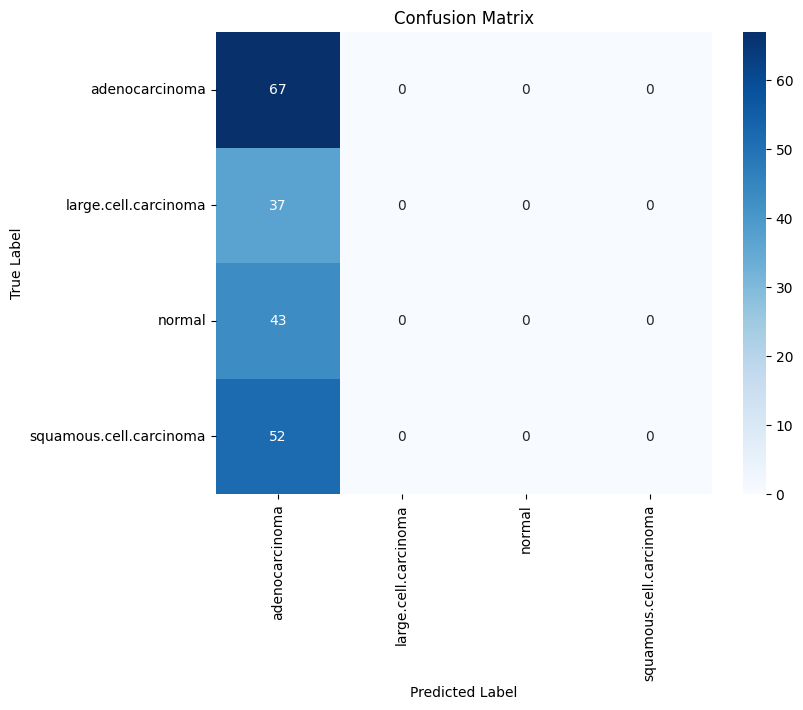

In [19]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    cohen_kappa_score,
    accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get True Labels and Predictions
validation_generator.reset()  # Reset the generator to start from the beginning
y_true = validation_generator.classes  # True labels
y_pred_probs = resnet_model.predict(validation_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Step 2: Compute Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# ROC-AUC Score (Multi-class)
roc_auc = roc_auc_score(
    tf.keras.utils.to_categorical(y_true, num_classes=len(classes)),  # One-hot encoded true labels
    y_pred_probs,  # Predicted probabilities
    multi_class='ovr',  # One-vs-Rest strategy for multi-class
    average='macro'  # Macro-average across classes
)

# Print Results
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define image dimensions and batch size
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 32

# Build the CNN model
cnn_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Output layer
])

# Compile the model
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,884 (42.61 MB)

 Trainable params: 11,170,180 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
training_history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 894ms/step - accuracy: 0.4860 - loss: 1.5880 - val_accuracy: 0.3367 - val_loss: 1.5822
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - accuracy: 0.5844 - loss: 1.0428 - val_accuracy: 0.2613 - val_loss: 2.5285
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 709ms/step - accuracy: 0.6776 - loss: 0.8631 - val_accuracy: 0.2613 - val_loss: 3.1179
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.6595 - loss: 0.8030 - val_accuracy: 0.2613 - val_loss: 3.5329
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.6985 - loss: 0.7597 - val_accuracy: 0.2814 - val_loss: 3.4007
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.7330 - loss: 0.6917 - val_accuracy: 0.3216 - val_loss: 3.9360


In [22]:
# Evaluate the model
validation_loss, validation_accuracy = cnn_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - accuracy: 0.3329 - loss: 1.5713
Validation Loss: 1.5764411687850952
Validation Accuracy: 0.3216080367565155


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step
Validation Accuracy: 0.2714
Cohen's Kappa: -0.0209
ROC-AUC Score (Macro): 0.4964

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.33      0.33      0.33        67
   large.cell.carcinoma       0.00      0.00      0.00        37
                 normal       0.00      0.00      0.00        43
squamous.cell.carcinoma       0.24      0.62      0.35        52

               accuracy                           0.27       199
              macro avg       0.14      0.24      0.17       199
           weighted avg       0.18      0.27      0.20       199



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

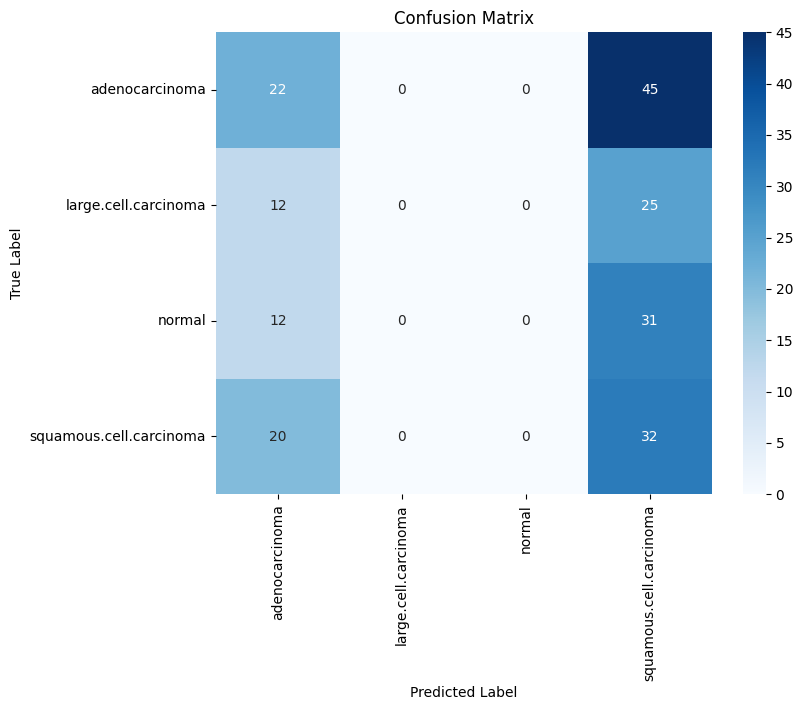

In [23]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    cohen_kappa_score,
    accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get True Labels and Predictions
validation_generator.reset()  # Reset the generator to start from the beginning
y_true = validation_generator.classes  # True labels
y_pred_probs = cnn_model.predict(validation_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Step 2: Compute Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# ROC-AUC Score (Multi-class)
roc_auc = roc_auc_score(
    tf.keras.utils.to_categorical(y_true, num_classes=len(classes)),  # One-hot encoded true labels
    y_pred_probs,  # Predicted probabilities
    multi_class='ovr',  # One-vs-Rest strategy for multi-class
    average='macro'  # Macro-average across classes
)

# Print Results
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
from tensorflow.keras.models import load_model

# Load the best models
cnn_model = load_model('best_cnn_model.keras')
mobilenet_model = load_model('best_model.keras')
resnet_model = load_model('best_resnet_model.keras')

In [26]:
def evaluate_model(model, generator, classes):
    # Reset the generator
    generator.reset()

    # Get true labels and predictions
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    kappa = cohen_kappa_score(y_true, y_pred)
    roc_auc = roc_auc_score(
        tf.keras.utils.to_categorical(y_true, num_classes=len(classes)),
        y_pred_probs,
        multi_class='ovr',
        average='macro'
    )

    # Return results
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'roc_auc': roc_auc,
        'classification_report': classification_rep,
        'confusion_matrix': conf_matrix
    }

In [27]:
# Evaluate models
cnn_results = evaluate_model(cnn_model, validation_generator, classes)
mobilenet_results = evaluate_model(mobilenet_model, validation_generator, classes)
resnet_results = evaluate_model(resnet_model, validation_generator, classes)

# Print results
print("CNN Results:")
print(f"Accuracy: {cnn_results['accuracy']:.4f}, Kappa: {cnn_results['kappa']:.4f}, ROC-AUC: {cnn_results['roc_auc']:.4f}")

print("\nMobileNetV2 Results:")
print(f"Accuracy: {mobilenet_results['accuracy']:.4f}, Kappa: {mobilenet_results['kappa']:.4f}, ROC-AUC: {mobilenet_results['roc_auc']:.4f}")

print("\nResNet Results:")
print(f"Accuracy: {resnet_results['accuracy']:.4f}, Kappa: {resnet_results['kappa']:.4f}, ROC-AUC: {resnet_results['roc_auc']:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 872ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 944ms/step
CNN Results:
Accuracy: 0.2714, Kappa: -0.0220, ROC-AUC: 0.5269

MobileNetV2 Results:
Accuracy: 0.2563, Kappa: -0.0199, ROC-AUC: 0.5018

ResNet Results:
Accuracy: 0.2663, Kappa: -0.0429, ROC-AUC: 0.4381


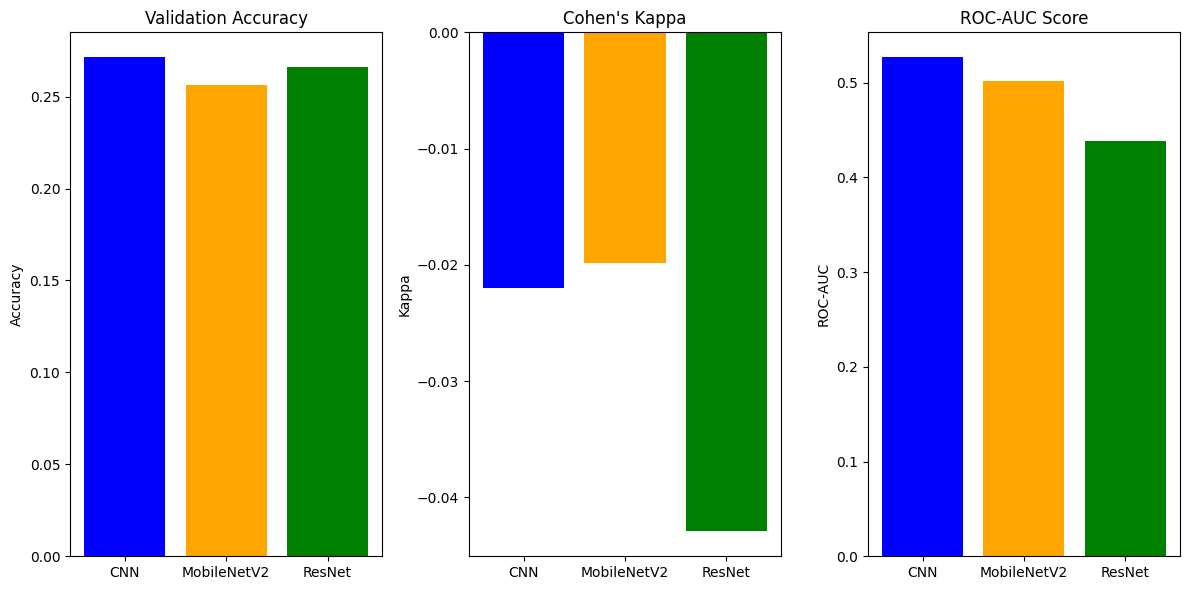

In [28]:
import matplotlib.pyplot as plt

# Metrics for comparison
models = ['CNN', 'MobileNetV2', 'ResNet']
accuracies = [cnn_results['accuracy'], mobilenet_results['accuracy'], resnet_results['accuracy']]
kappas = [cnn_results['kappa'], mobilenet_results['kappa'], resnet_results['kappa']]
roc_aucs = [cnn_results['roc_auc'], mobilenet_results['roc_auc'], resnet_results['roc_auc']]

# Plot
x = range(len(models))
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(x, accuracies, color=['blue', 'orange', 'green'])
plt.xticks(x, models)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.bar(x, kappas, color=['blue', 'orange', 'green'])
plt.xticks(x, models)
plt.title("Cohen's Kappa")
plt.ylabel('Kappa')

plt.subplot(1, 3, 3)
plt.bar(x, roc_aucs, color=['blue', 'orange', 'green'])
plt.xticks(x, models)
plt.title('ROC-AUC Score')
plt.ylabel('ROC-AUC')

plt.tight_layout()
plt.show()

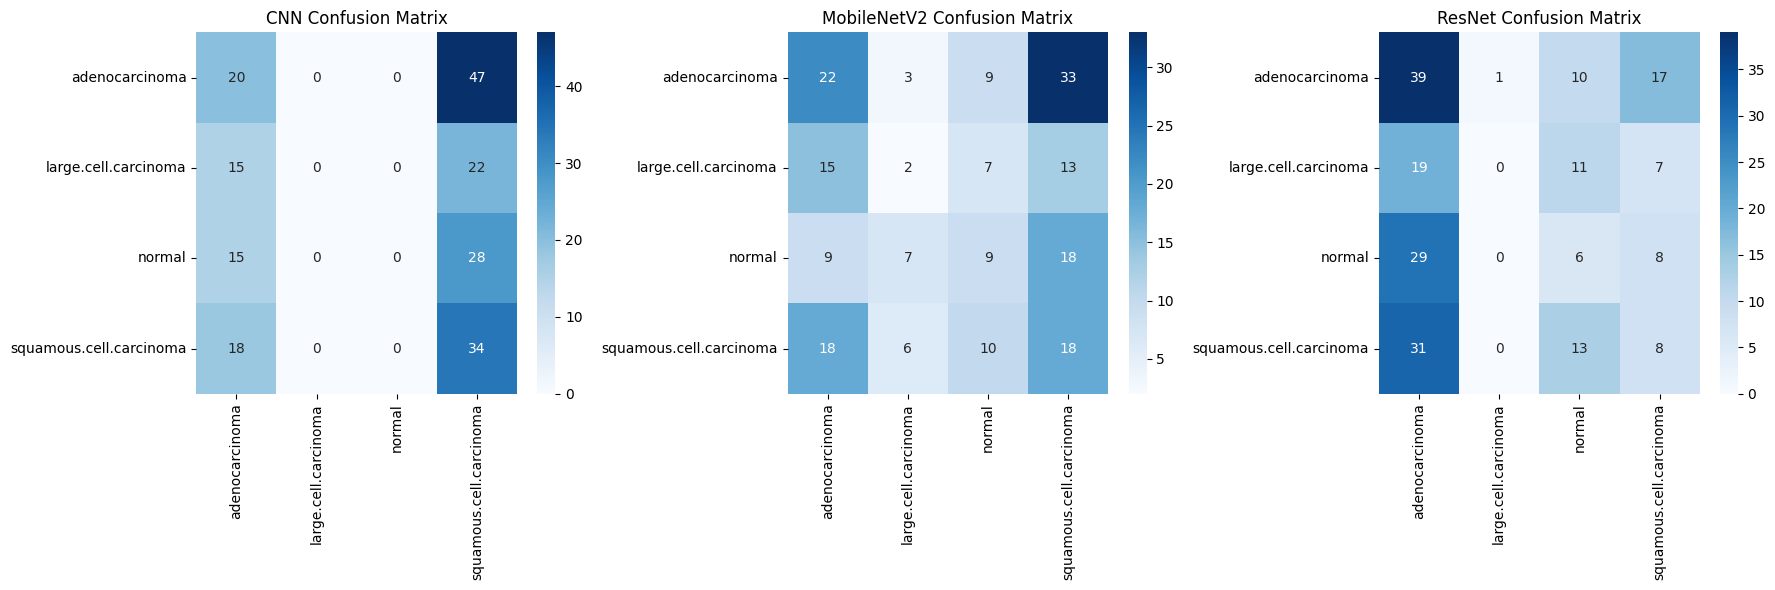

In [29]:
import seaborn as sns

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cnn_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=classes, yticklabels=classes)
axes[0].set_title("CNN Confusion Matrix")

sns.heatmap(mobilenet_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=classes, yticklabels=classes)
axes[1].set_title("MobileNetV2 Confusion Matrix")

sns.heatmap(resnet_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[2], xticklabels=classes, yticklabels=classes)
axes[2].set_title("ResNet Confusion Matrix")

plt.tight_layout()
plt.show()

In [30]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(data_dir, cls)))} images")

adenocarcinoma: 338 images
large.cell.carcinoma: 187 images
normal: 215 images
squamous.cell.carcinoma: 260 images


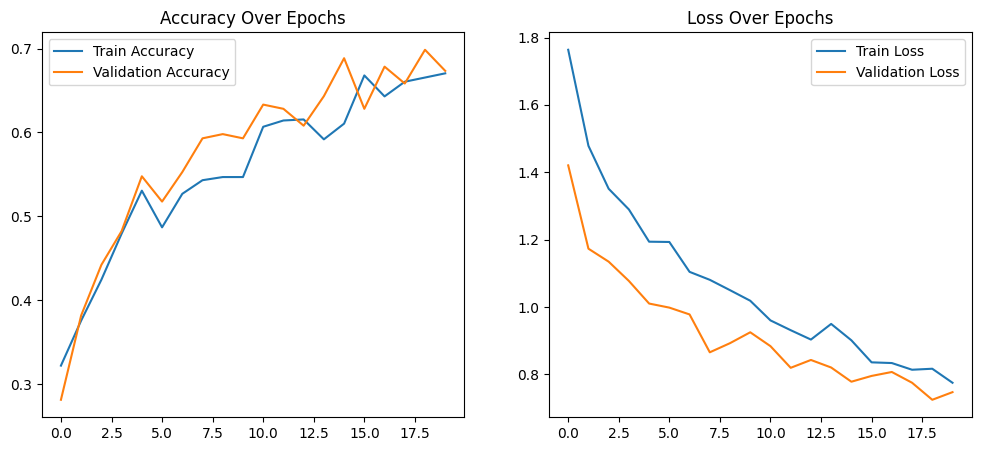

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [32]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(data_dir, cls)))} images")

adenocarcinoma: 338 images
large.cell.carcinoma: 187 images
normal: 215 images
squamous.cell.carcinoma: 260 images


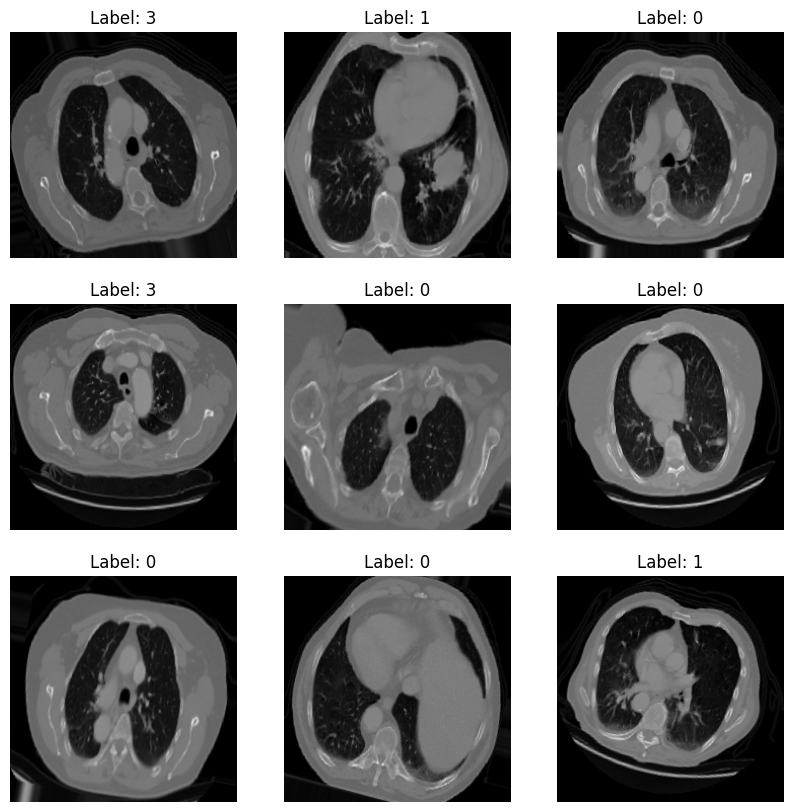

In [33]:
x_batch, y_batch = next(iter(train_generator))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {np.argmax(y_batch[i])}")
    plt.axis('off')
plt.show()

In [34]:

# Define the path to the folder where you want to save the models
save_dir = '/content/drive/MyDrive/models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
print(f"Models will be saved to: {save_dir}")

Models will be saved to: /content/drive/MyDrive/models


In [35]:
# Save the custom CNN model
cnn_save_path = os.path.join(save_dir, 'best_cnn_model.keras')
cnn_model.save(cnn_save_path)
print(f"Custom CNN model saved to: {cnn_save_path}")

Custom CNN model saved to: /content/drive/MyDrive/models/best_cnn_model.keras


In [36]:
# Save the MobileNetV2 model
mobilenet_save_path = os.path.join(save_dir, 'best_model.keras')
mobilenet_model.save(mobilenet_save_path)
print(f"MobileNetV2 model saved to: {mobilenet_save_path}")

MobileNetV2 model saved to: /content/drive/MyDrive/models/best_model.keras


In [37]:
# Save the ResNet model
resnet_save_path = os.path.join(save_dir, 'best_resnet_model.keras')
resnet_model.save(resnet_save_path)
print(f"ResNet model saved to: {resnet_save_path}")

ResNet model saved to: /content/drive/MyDrive/models/best_resnet_model.keras


In [38]:
# List the contents of the save directory
print("Saved models:")
for file in os.listdir(save_dir):
    print(file)

Saved models:
best_cnn_model.keras
best_model.keras
best_resnet_model.keras
